In [1]:
# System packages
import io
from io import StringIO
import os
import sys

# Image packages
from IPython.display import Image
from PIL import Image as Image_PIL
from PIL import Image 
from scipy.ndimage import gaussian_filter
import cv2
# Table packages
import numpy as np
import pandas as pd

# Pyspark packages
from pyspark.sql.functions import udf
from pyspark.sql.functions import input_file_name
from pyspark.sql.types import StringType, FloatType, ArrayType
import findspark
findspark.init()
from pyspark import SparkContext, SparkConf
from pyspark.ml.feature import CountVectorizer
from pyspark.sql import Row, SparkSession 
from sklearn import preprocessing
from pyspark.mllib.clustering import KMeans
from pyspark.ml.image import ImageSchema

# Write on S3
import boto.s3
import boto3

# PCA
from sklearn.decomposition import PCA
from functions import *

##  Dataset Description

### Total number of images: 90483. Training set size: 67692 images (one fruit or vegetable per image). Test set size: 22688 images (one fruit or vegetable per image). Multi-fruits set size: 103 images (more than one fruit (or fruit class) per image) Number of classes: 131 (fruits and vegetables). Image size: 100x100 pixels. Filename format: image_index_100.jpg (e.g. 32_100.jpg) or r_image_index_100.jpg (e.g. r_32_100.jpg) or r2_image_index_100.jpg or r3_image_index_100.jpg. "r" stands for rotated fruit. "r2" means that the fruit was rotated around the 3rd axis. "100" comes from image size (100x100 pixels). Different varieties of the same fruit (apple for instance) are stored as belonging to different classes.

## Importing Dataset from S3

In [2]:
#os.environ["PYSPARK_PYTHON"]

In [3]:
#s3_path = "s3a://openclassroom-project-8/fruits-360/"

In [4]:
local_path="./Training/*"

In [5]:
local_path_out_training='/Users/migueljosebernalmora/P8_Bernal_Miguel/'

In [6]:
#sc = SparkContext()

In [7]:
spark = SparkSession.builder.master('local[*]').appName('OC-P8').getOrCreate()
sc = spark.sparkContext

In [8]:
#df_img_s3 = spark.read.format("image").load(s3_path)

In [9]:
#df_img = spark.read.format("image").load(local_path)


### Observing an Spark DataFrame for path an image data

In [10]:
#df_img =  spark.read.format("image").option("recursiveFileLookup","true").load(local_path)
df_img = sc.binaryFiles(local_path)
df_img = df_img.toDF(schema=['path', 'data'])

In [11]:
df_img.show()

+--------------------+--------------------+
|                path|                data|
+--------------------+--------------------+
|file:/Users/migue...|[FF D8 FF E0 00 1...|
|file:/Users/migue...|[FF D8 FF E0 00 1...|
|file:/Users/migue...|[FF D8 FF E0 00 1...|
|file:/Users/migue...|[FF D8 FF E0 00 1...|
|file:/Users/migue...|[FF D8 FF E0 00 1...|
|file:/Users/migue...|[FF D8 FF E0 00 1...|
|file:/Users/migue...|[FF D8 FF E0 00 1...|
|file:/Users/migue...|[FF D8 FF E0 00 1...|
|file:/Users/migue...|[FF D8 FF E0 00 1...|
|file:/Users/migue...|[FF D8 FF E0 00 1...|
|file:/Users/migue...|[FF D8 FF E0 00 1...|
|file:/Users/migue...|[FF D8 FF E0 00 1...|
|file:/Users/migue...|[FF D8 FF E0 00 1...|
|file:/Users/migue...|[FF D8 FF E0 00 1...|
|file:/Users/migue...|[FF D8 FF E0 00 1...|
|file:/Users/migue...|[FF D8 FF E0 00 1...|
|file:/Users/migue...|[FF D8 FF E0 00 1...|
|file:/Users/migue...|[FF D8 FF E0 00 1...|
|file:/Users/migue...|[FF D8 FF E0 00 1...|
|file:/Users/migue...|[FF D8 FF 

In [12]:
#df_img = df_img.withColumn('path', input_file_name())

### Observing Path, data and Categorie

In [13]:
def get_type_from_folder_name(path):
    if len(path):
        return path.split('/')[-2]
    else:
        return ''

In [14]:
udf_categorie = udf(get_type_from_folder_name, StringType())
df_img = df_img.withColumn('categorie', udf_categorie('path'))

In [15]:
df_img.show()

+--------------------+--------------------+------------------+
|                path|                data|         categorie|
+--------------------+--------------------+------------------+
|file:/Users/migue...|[FF D8 FF E0 00 1...|Apple_Crimson_Snow|
|file:/Users/migue...|[FF D8 FF E0 00 1...|Apple_Crimson_Snow|
|file:/Users/migue...|[FF D8 FF E0 00 1...|Apple_Crimson_Snow|
|file:/Users/migue...|[FF D8 FF E0 00 1...|Apple_Crimson_Snow|
|file:/Users/migue...|[FF D8 FF E0 00 1...|Apple_Crimson_Snow|
|file:/Users/migue...|[FF D8 FF E0 00 1...|Apple_Crimson_Snow|
|file:/Users/migue...|[FF D8 FF E0 00 1...|Apple_Crimson_Snow|
|file:/Users/migue...|[FF D8 FF E0 00 1...|Apple_Crimson_Snow|
|file:/Users/migue...|[FF D8 FF E0 00 1...|Apple_Crimson_Snow|
|file:/Users/migue...|[FF D8 FF E0 00 1...|Apple_Crimson_Snow|
|file:/Users/migue...|[FF D8 FF E0 00 1...|Apple_Crimson_Snow|
|file:/Users/migue...|[FF D8 FF E0 00 1...|Apple_Crimson_Snow|
|file:/Users/migue...|[FF D8 FF E0 00 1...|Apple_Crimso

In [16]:
#def strip_file_protocol_if_present(path):
    #return path.replace('file://', '')

In [17]:
#udf_strip_file_protocol_if_present = udf(strip_file_protocol_if_present, StringType())
#df_img = df_img.withColumn('path', udf_strip_file_protocol_if_present(local_path))

In [18]:
df_new=df_img.toPandas() 

In [19]:
df_new

,path,data,categorie
0,file:/Users/migueljosebernalmora/P8_Bernal_Mig...,"[255, 216, 255, 224, 0, 16, 74, 70, 73, 70, 0,...",Apple_Crimson_Snow
1,file:/Users/migueljosebernalmora/P8_Bernal_Mig...,"[255, 216, 255, 224, 0, 16, 74, 70, 73, 70, 0,...",Apple_Crimson_Snow
2,file:/Users/migueljosebernalmora/P8_Bernal_Mig...,"[255, 216, 255, 224, 0, 16, 74, 70, 73, 70, 0,...",Apple_Crimson_Snow
3,file:/Users/migueljosebernalmora/P8_Bernal_Mig...,"[255, 216, 255, 224, 0, 16, 74, 70, 73, 70, 0,...",Apple_Crimson_Snow
4,file:/Users/migueljosebernalmora/P8_Bernal_Mig...,"[255, 216, 255, 224, 0, 16, 74, 70, 73, 70, 0,...",Apple_Crimson_Snow
...,...,...,...
931,file:/Users/migueljosebernalmora/P8_Bernal_Mig...,"[255, 216, 255, 224, 0, 16, 74, 70, 73, 70, 0,...",Apple_Braeburn
932,file:/Users/migueljosebernalmora/P8_Bernal_Mig...,"[255, 216, 255, 224, 0, 16, 74, 70, 73, 70, 0,...",Apple_Braeburn
933,file:/Users/migueljosebernalmora/P8_Bernal_Mig...,"[255, 216, 255, 224, 0, 16, 74, 70, 73, 70, 0,...",Apple_Braeburn
934,file:/Users/migueljosebernalmora/P8_Bernal_Mig...,"[255, 216, 255, 224, 0, 16, 74, 70, 73, 70, 0,...",Apple_Braeburn


In [20]:
## number of pictures
len(np.array(df_new['path']))

936

### Observing with pandas our data

In [21]:
image_path=df_new['path']

In [22]:
image_data=df_new['data']

In [23]:
image_name=df_new['categorie']

In [24]:
image_data[0]

bytearray(b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00\x00\x01\x00\x01\x00\x00\xff\xdb\x00C\x00\x02\x01\x01\x01\x01\x01\x02\x01\x01\x01\x02\x02\x02\x02\x02\x04\x03\x02\x02\x02\x02\x05\x04\x04\x03\x04\x06\x05\x06\x06\x06\x05\x06\x06\x06\x07\t\x08\x06\x07\t\x07\x06\x06\x08\x0b\x08\t\n\n\n\n\n\x06\x08\x0b\x0c\x0b\n\x0c\t\n\n\n\xff\xdb\x00C\x01\x02\x02\x02\x02\x02\x02\x05\x03\x03\x05\n\x07\x06\x07\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\xff\xc0\x00\x11\x08\x00d\x00d\x03\x01"\x00\x02\x11\x01\x03\x11\x01\xff\xc4\x00\x1f\x00\x00\x01\x05\x01\x01\x01\x01\x01\x01\x00\x00\x00\x00\x00\x00\x00\x00\x01\x02\x03\x04\x05\x06\x07\x08\t\n\x0b\xff\xc4\x00\xb5\x10\x00\x02\x01\x03\x03\x02\x04\x03\x05\x05\x04\x04\x00\x00\x01}\x01\x02\x03\x00\x04\x11\x05\x12!1A\x06\x13Qa\x07"q\x142\x81\x91\xa1\x08#B\xb1\xc1\x15R\xd1\xf0$3br\x82\t\n\x16\x17\x18\x19\x1a%&\'()*456789:CDEFGHIJSTUVWXYZcdefghijstuvwxyz\x83\x84\x85\x86\x87\x88\x89\x8a\x92\x93\x94\x95\x96\

In [25]:
image_name[0]

'Apple_Crimson_Snow'

In [26]:
image_path[0]

'file:/Users/migueljosebernalmora/P8_Bernal_Miguel/Training/Apple_Crimson_Snow/r_236_100.jpg'

In [27]:
image_img = Image.open(io.BytesIO(image_data[0]))

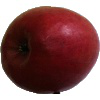

In [28]:
image_img

## We have a function for image treatment and getting descriptors:  

### Reads bynary file and takes the category value. Also detects the descriptors and makes image treatment.



In [29]:
def get_descriptors(image): 
      
    try:
        # From bytes to image
        name, img = image
        image_img = Image.open(io.BytesIO(img))
        category = name.split('/')[-2]
        # Convert to numpy
        np_img = np.array(image_img)
        # Image Treatment
        np_img = cv2.cvtColor(np_img, cv2.COLOR_BGR2GRAY)
        np_img = cv2.equalizeHist(np_img)
        np_img = gaussian_filter(np_img, sigma=0.05)
        # Get descriptors
        sift = cv2.xfeatures2d.SIFT_create()
        kp_sift, desc = sift.detectAndCompute(np_img, None)
        
        #orb = cv2.ORB_create(nfeatures=50)
        #keypoints_orb, desc = orb.detectAndCompute(np_img, None)
        
        # Check if none arefound
        if desc is None:
            cat = np.full(1, category)
        else:
            cat = np.full(desc.shape[0], category)
    except:
        cat = np.full(1, "error")
        desc = None
    return cat, desc

## We have a function that: 

### Loads the images into spark context by using the get_descriptors function and the image path. It removes descriptors that have 0 values and it saves the category (fruits/vegetables) list. Flatmap is used to list categories and descriptors separetely.

In [30]:
def get_categories_descriptors(IMAGE_PATH):
    
    # Takes all images and names
    images = sc.binaryFiles(local_path)
    # Rescale all images and get descriptors. return (category, array of descriptors)
    tuples_decriptors = images.map(lambda img: get_descriptors(img))
    # Removes the descriptors which return nothing
    descriptors_filtered = tuples_decriptors.filter(lambda x: x[1] is not None)
    # List the descriptors for each category
    desc_cat = descriptors_filtered\
    .map(lambda x: (Row(fileName=x[0], features=x[1].tolist()))).cache()
    # Flat the descriptors and categories
    flat_desc = desc_cat.flatMap(lambda x: x['features'])
    flat_cat = desc_cat.flatMap(lambda x: x['fileName'])
    # Collect only the categories
    cat_collected = flat_cat.collect()
    return flat_desc, cat_collected

In [31]:
 flat_desc, cat_collected = get_categories_descriptors(local_path)

In [32]:
flat_desc

PythonRDD[21] at RDD at PythonRDD.scala:53

In [33]:
## Number of category values and descriptors
len(np.array(cat_collected))

39941

###  Function that runs a kmeans to find descriptor clusters where k is established as:
### Fruits/vegetables*10

In [34]:
def run_kmeans(flat_desc, cat_collected):
    
    # Select number of clusters
    K = len(np.unique(cat_collected)) * 1
    # Train the model
    model = KMeans\
    .train(flat_desc, K, maxIterations=1000, initializationMode="random")
    return model

In [35]:
 model = run_kmeans(flat_desc, cat_collected)

### Calculating cluster predictions

In [36]:
def predict_kmeans(model, values):
    """ Predict the clusters with the model and values given."""
    
    # Get the results of clustering
    transformed = model.predict(values)
    # Collect
    predictions = transformed.collect()
    return predictions

In [37]:
predictions = predict_kmeans(model, flat_desc)

In [38]:
## Number of predictions
len(predictions)

39941

## Function that creates  a bag of visual words Spark using map and reduceByKey and a CountVectorizer so we have a cluster (feature) counting per image

In [39]:
def bag_word_creation(cat_collected, predictions):

    # Label the categories
    le = preprocessing.LabelEncoder()
    label_categories = le.fit_transform(cat_collected)
    # Concatenate the categories and prediction
    numpy_arr = np.concatenate((np.array(label_categories).reshape(-1,1), 
                                np.array(predictions).reshape(-1,1)), axis=1)
    pandas_df= pd.DataFrame(numpy_arr, columns=['id', 'prediction'])
    # Convert into spark DataFrame
    spark = SparkSession(sc)
    spark_df = spark.createDataFrame(pandas_df)
    # List all clusters for each category
    rdd_words = spark_df.select('id', 'prediction')\
    .rdd.map(lambda x:x)\
    .reduceByKey(lambda a,b: str(a) + ',' + str(b))
    # From that string of clusters/words we get a list of words
    df_words = rdd_words\
    .map(lambda tupl_words: (tupl_words[0], str(tupl_words[1]).split(',')))\
    .toDF(['category','words'])
    # Creates a vector from the count of words for each category
    vectorizer = CountVectorizer(inputCol="words", outputCol="bag_of_words")
    vectorizer_transformer = vectorizer.fit(df_words)
    bag_of_words = vectorizer_transformer\
    .transform(df_words)\
    .select('category', 'bag_of_words')
    return bag_of_words


In [40]:
bag_of_words = bag_word_creation(cat_collected, predictions)

### Some data Visualization

In [41]:
le = preprocessing.LabelEncoder()
label_categories = le.fit_transform(cat_collected)
# Concatenate the categories and prediction
numpy_arr = np.concatenate((np.array(label_categories).reshape(-1,1), 
                            np.array(predictions).reshape(-1,1)), axis=1)

In [42]:
numpy_arr

array([[1, 0],
       [1, 0],
       [1, 1],
       ...,
       [0, 0],
       [0, 0],
       [0, 0]])

In [43]:
pandas_df= pd.DataFrame(numpy_arr, columns=['id', 'prediction'])

In [44]:
df_predictions = pandas_df['prediction'].map(str)

In [45]:
pred_text = df_predictions.tolist()

In [46]:
def convert_list_to_string(org_list, seperator=' '):
    """ Convert list to string, by joining all item in list with given separator.
        Returns the concatenated string """
    return seperator.join(org_list)

In [47]:
full_str = convert_list_to_string(pred_text)

In [48]:
print(full_str)

0 0 1 0 0 1 0 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 0 0 0 0 0 1 1 0 0 1 1 0 0 1 0 1 1 1 0 1 1 0 0 1 1 0 0 0 0 0 0 1 0 1 0 1 1 0 1 1 1 0 0 1 1 1 0 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 0 0 0 1 0 1 0 1 1 0 1 1 0 0 1 0 1 1 1 0 0 0 1 1 0 1 1 1 1 0 1 1 0 0 0 1 1 1 0 0 0 0 1 0 0 1 1 0 0 1 1 1 1 1 0 1 1 0 0 1 0 1 1 0 0 0 1 0 1 0 1 1 1 1 1 1 1 0 0 0 1 0 1 0 0 1 0 0 1 0 0 0 0 0 1 1 1 1 0 0 0 1 0 0 0 0 1 1 1 0 0 1 1 1 1 0 1 1 1 1 1 0 1 1 0 1 1 1 1 0 0 1 0 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 0 1 1 1 0 1 1 0 0 0 0 0 1 0 0 1 0 0 1 0 0 1 0 0 1 0 0 1 1 1 0 1 1 0 1 0 1 1 1 0 1 1 1 1 0 0 0 0 1 1 1 0 1 1 1 0 1 1 1 1 1 0 1 1 1 0 1 0 1 0 0 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 0 1 0 1 1 1 1 0 1 1 1 1 1 1 0 1 1 1 0 0 1 1 0 1 1 1 1 0 0 1 1 1 1 1 0 1 1 1 0 1 1 1 1 1 0 0 1 1 0 1 0 1 1 0 1 1 0 1 1 1 1 1 1 1 1 0 1 0 1 1 1 1 0 1 1 1 1 1 1 0 1 0 0 0 1 0 0 0 1 0 0 1 0 0 0 0 0 0 1 0 1 1 0 0 0 1 1 0 1 0 0 1 0 1 0 1 1 0 1 1 1 0 1 1 1 1 0 0 1 1 1 0 0 0 0 1 1 1 1 1 1 0 0 1 1 0 0 1 1 0 1 0 0 0 0 1 0 0 1 0 0 1 0 0 1 1 0 1 0 0 0 0 0 0 

In [49]:
bag_of_words.show()

+--------+--------------------+
|category|        bag_of_words|
+--------+--------------------+
|       0|(2,[0,1],[11911.0...|
|       1|(2,[0,1],[10201.0...|
+--------+--------------------+



## Matrix Consturction using numpy and Pandas

In [50]:
panda_bag=bag_of_words.toPandas()

In [51]:
panda_bag['bag_of_words'][0]

SparseVector(2, {0: 11911.0, 1: 10226.0})

In [52]:
DF_Features=pd.DataFrame(panda_bag['bag_of_words'])

In [53]:
Matrix=panda_bag['bag_of_words'].apply(lambda x : np.array(x.toArray())).to_numpy().reshape(-1,1)

In [54]:
pd.DataFrame(Matrix)

,0
0,"[11911.0, 10226.0]"
1,"[10201.0, 7603.0]"


In [55]:
features = np.apply_along_axis(lambda x : x[0], 1, Matrix)

In [56]:
pd.DataFrame(features)

,0,1
0,11911.0,10226.0
1,10201.0,7603.0


In [57]:
Matrix['labels']=panda_bag['category']

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

In [ ]:
def save_bag(bag_of_words, cat_collected, name):
    """ Save the bag of word locally or on S3"""
    
    print("--------- Save the bag of words ---------")
    # Transform into Pandas to save the bag of visual words
    pandaDf = bag_of_words.toPandas()
    pandaDf["category"] = np.unique(cat_collected)
    # Save the DataFrame
    
    pandaDf.to_csv(name, index=False)
    

In [ ]:
save_bag(bag_of_words, cat_collected, 'Reduced_Matrix')

In [ ]:
Reduced_Matrix=pd.read_csv('Reduced_Matrix')

In [ ]:
Reduced_Matrix